In [1]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

In [2]:
simulation = Sphere(size = 10, nPoints = 501, volFrac = 0.05)
simulation.place_shape()

volume fraction is 0.00214, radius is 0.99, center at (0.6,-1.7,-2.5) 
volume fraction is 0.00325, radius is 0.99, center at (0.7,-2.0,-2.4) 
volume fraction is 0.00524, radius is 0.99, center at (3.4,0.0,3.0) 
volume fraction is 0.00794, radius is 0.99, center at (2.1,3.6,3.5) 
volume fraction is 0.01177, radius is 0.99, center at (-3.2,1.1,-0.7) 
volume fraction is 0.01695, radius is 0.99, center at (-1.8,-1.3,2.3) 
volume fraction is 0.01902, radius is 0.99, center at (3.3,0.2,0.6) 
volume fraction is 0.02178, radius is 0.99, center at (-0.1,-4.0,-1.4) 
volume fraction is 0.02469, radius is 0.99, center at (-3.5,-1.1,3.3) 
volume fraction is 0.02810, radius is 0.99, center at (1.2,1.5,2.0) 
volume fraction is 0.03179, radius is 0.99, center at (1.6,1.6,0.8) 
volume fraction is 0.03515, radius is 0.99, center at (4.0,-3.6,3.0) 
volume fraction is 0.04005, radius is 0.99, center at (-3.0,1.1,3.0) 
volume fraction is 0.04240, radius is 0.99, center at (-1.7,0.6,-2.7) 
volume fraction i

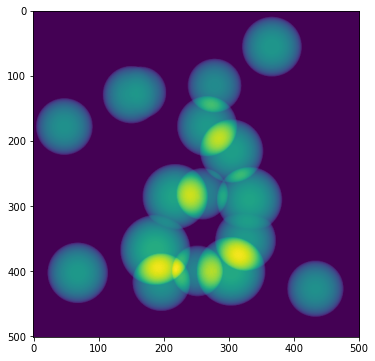

In [3]:
plt.figure(figsize=(6,6))
plt.imshow(simulation.density.sum(axis=0))

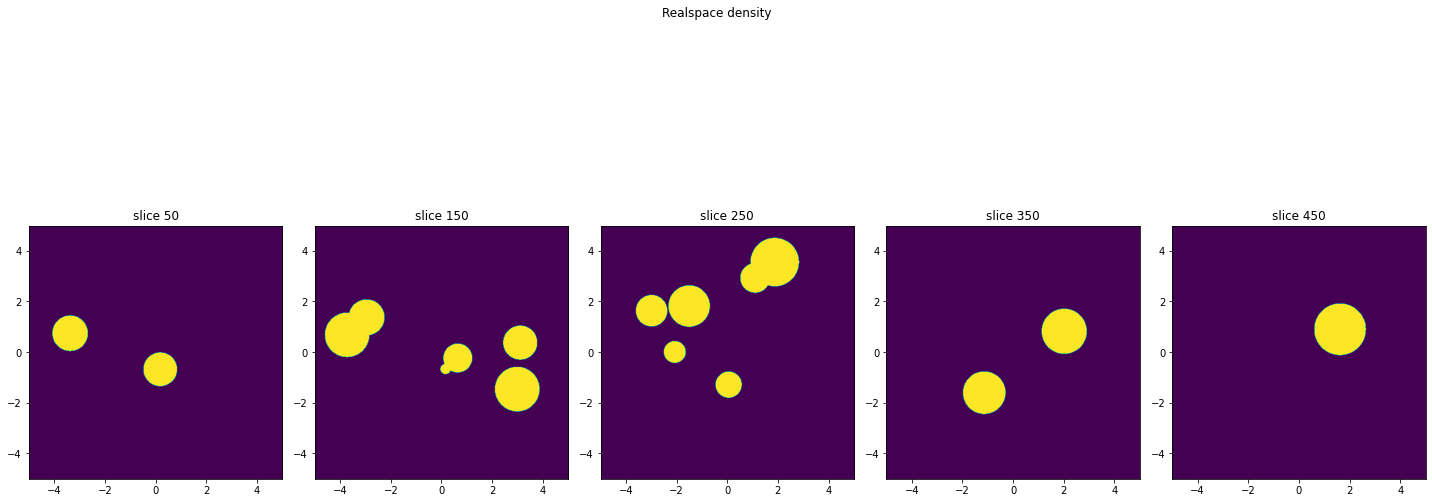

In [3]:
plot_slices(simulation.density, simulation.grid)

In [4]:
#plot_3D_structure(simulation.density, simulation.grid, realspace=True)

In [4]:
simulation.calculate_custom_FTI_3D(device = 'cpu')
simulation.calculate_custom_FTI_3D_slice(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cpu')
simulation.sinc()

/home/slaskina/SAXS-simulations/SAXSsimulations/create_form.py:92: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/Copy.cpp:250.)
  if FT[k,:,:].any():


the maximal difference between the implementation of the FTI is 0.00965864211320877


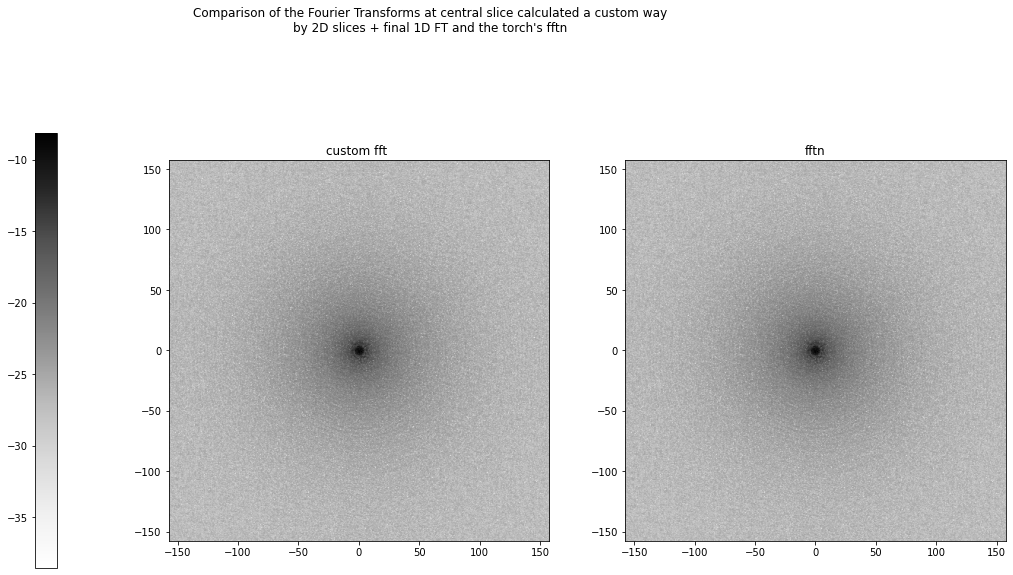

In [5]:
plot_FTI_version_center(simulation.FTI_slice_custom, simulation.FTI_slice_torch, simulation.qx)

the maximal difference between the implementation of the FTI is 0.02568071521818638


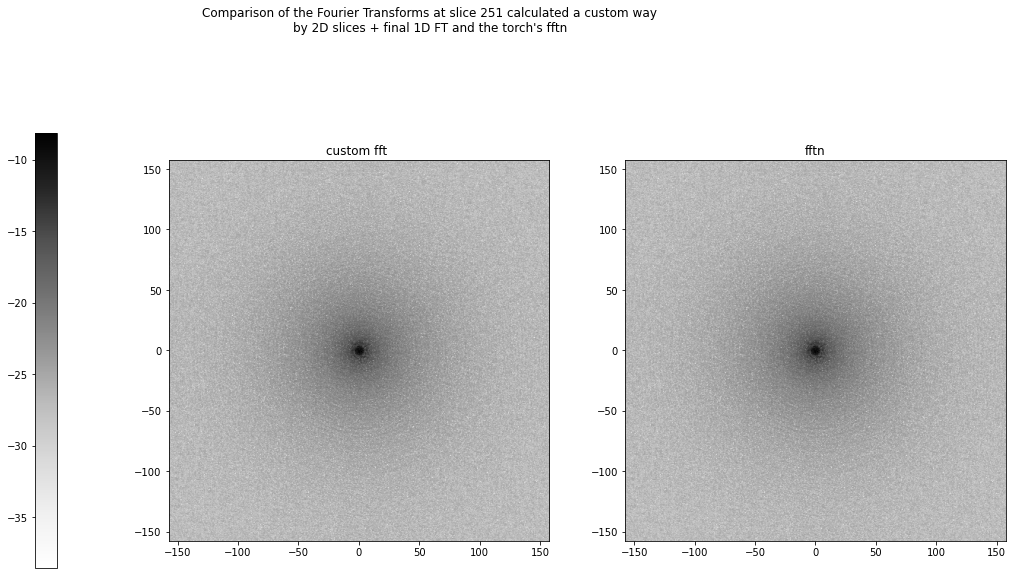

In [6]:
plot_FTI_version(simulation.FTI_custom, simulation.FTI_torch, simulation.qx,slice_number = 251)

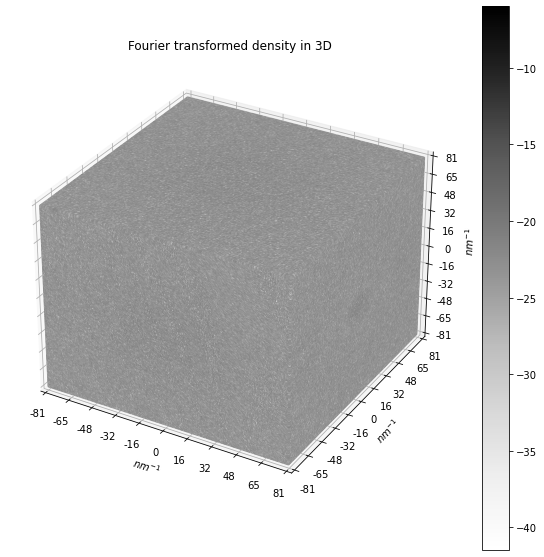

In [19]:
import torch
#plot_3D_structure(torch.from_numpy(simulation.FTI), simulation.qx, realspace= False)#, path = 'figures/FFT_spheres_example.png')

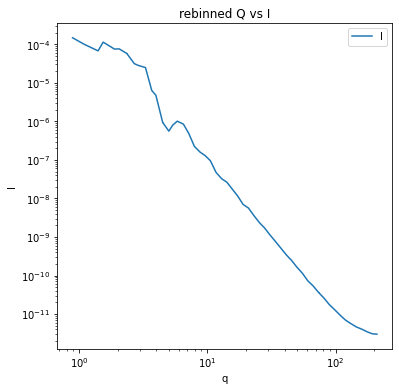

In [8]:
#simulation.reBin(200, slice = 'center')
#simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

In [10]:
simulation.init_sas_model()

AttributeError: 'Sphere' object has no attribute 'binned_data'

In [38]:
simulation.init_sas_model()
simulation.update_scaling(6.5566e-06)
plot_simulation_vs_sas( simulation.binned_data, simulation.qx_sas, simulation.I_sas)

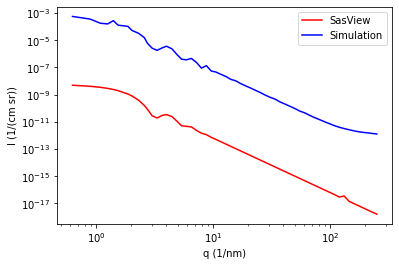

In [39]:
plot_simulation_vs_sas( simulation.binned_data, simulation.qx_sas, simulation.I_sas)

In [9]:
simulation.save_data(directory='dat_files')
print("the sphere file with radius {r:.3f}  is saved".format(r = simulation.rMean))

the sphere file with radius 0.994  is saved


In [13]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

simulation = Cylinder(size = 10, nPoints = 251, volFrac = 0.05)
simulation.place_shape(single = True, rMean = 0.8)
print(simulation.theta, simulation.phi,simulation.grid_space)

A: (-1.03,-1.35), C: (-1.90,-2.21)
Ellipse equation: (x-(-1.89))^2/0.88^2 +(y -(-2.21))^2/0.86^2<1, line equation: y > 0.99x-0.33
A: (-1.93,-2.26), C: (-1.83,-2.16)
Ellipse equation: (x-(-1.83))^2/0.88^2 +(y -(-2.16))^2/0.86^2<1, line equation: y > 0.99x-0.36
A: (-1.63,-1.96), C: (-1.86,-2.18)
Ellipse equation: (x-(-1.85))^2/0.88^2 +(y -(-2.18))^2/0.86^2<1, line equation: y > 0.99x-0.35
A: (-1.33,-1.66), C: (-1.88,-2.19)
Ellipse equation: (x-(-1.87))^2/0.88^2 +(y -(-2.19))^2/0.86^2<1, line equation: y > 0.99x-0.34
volume fraction is 0.01561, height is 7.83, radius is 0.80, center at (0.6,-0.3,-0.9) 
20.86804845737471 24.512124662282538 0.04


In [ ]:
plot_3D_structure(simulation.density, simulation.grid, realspace=True)

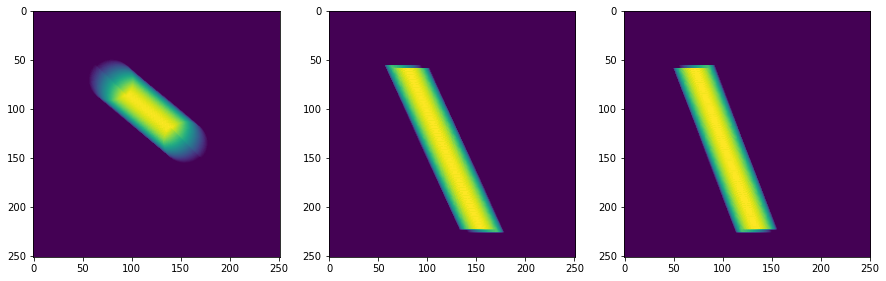

In [14]:
#plot_slices(simulation.density, simulation.grid, direction ='y')
plt_slices_sum(simulation)

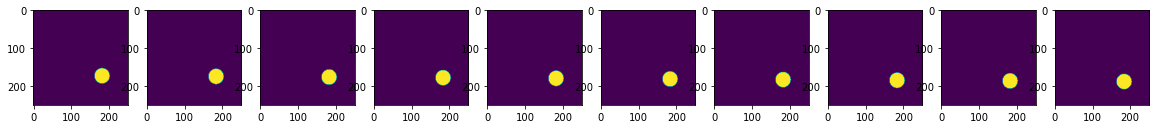

In [5]:
plot_slices_at_interval(10, 100, simulation, 'x')

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(simulation.density.sum(axis=2))

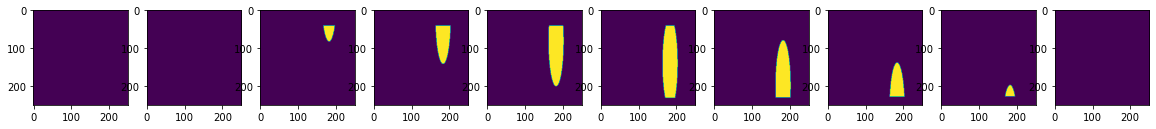

In [7]:
plot_slices_at_interval(10, 130, simulation, 'y')

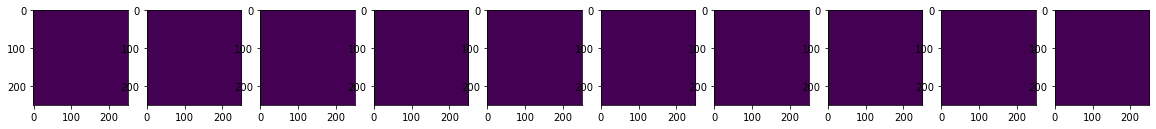

In [8]:
plot_slices_at_interval(10, 50, simulation, 'z')

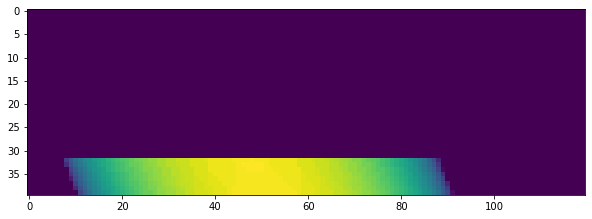

In [14]:
plt.figure(figsize = (10,10))
plt.imshow(simulation.density.sum(axis=2)[0:40,0:120])

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(simulation.density.sum(axis=2)[0:40,0:120])

/home/slaskina/SAXS-simulations/SAXSsimulations/create_form.py:92: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/Copy.cpp:250.)
  if FT[k,:,:].any():


the maximal difference between the implementation of the FTI is 0.08624882996082306


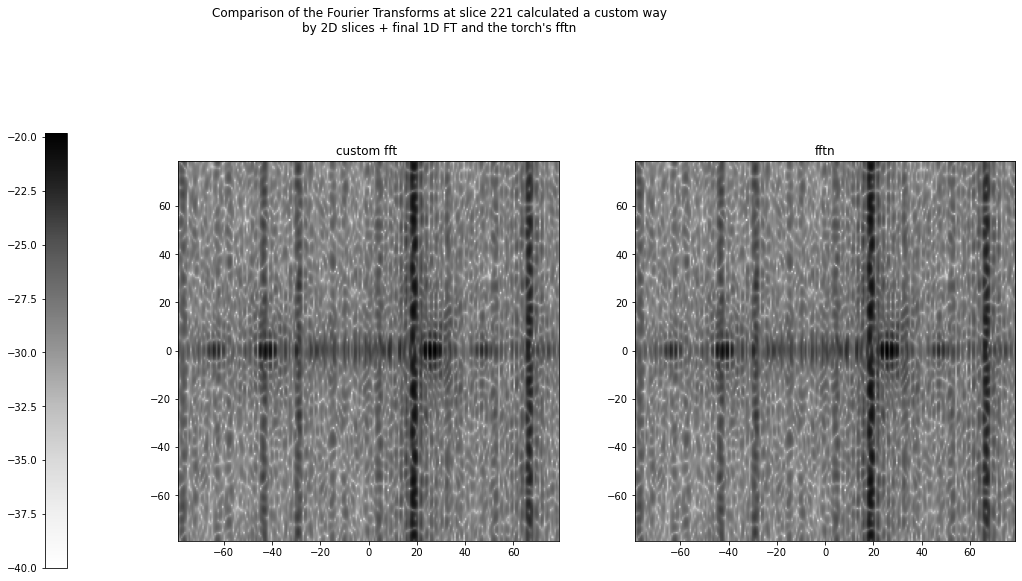

In [5]:
simulation.calculate_custom_FTI_3D(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cpu')
plot_FTI_version(simulation.FTI_custom, simulation.FTI_torch, simulation.qx)


In [7]:


def plt_slices_sim(simulation):
    fig,axs = plt.subplots(1,3,figsize = (15,5))
    ax = axs[0]
    im = ax.imshow(np.log(simulation.FTI_custom[120,:,:]), cmap = 'Greys')
    ax = axs[1]
    im = ax.imshow(np.log(simulation.FTI_custom[:,120,:]), cmap = 'Greys')
    ax = axs[2]
    im = ax.imshow(np.log(simulation.FTI_custom[:,:,120]), cmap = 'Greys')
    plt.show()    


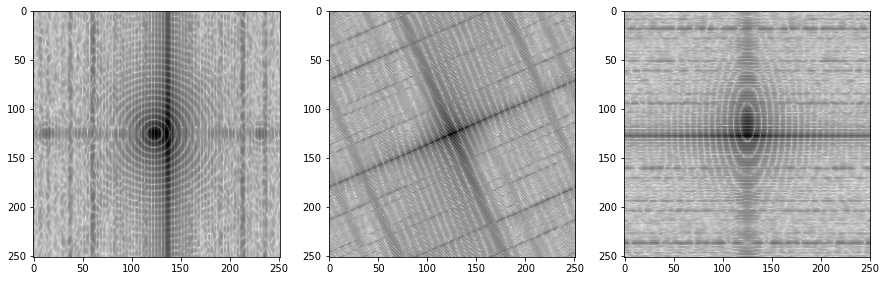

In [8]:
plt_slices_sim(simulation)

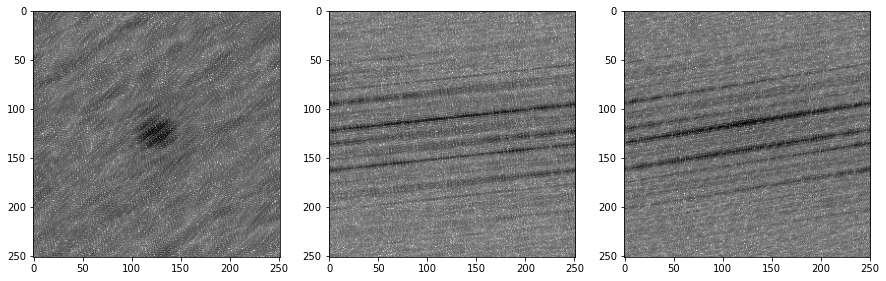

In [13]:
plt_slices_sim(simulation)

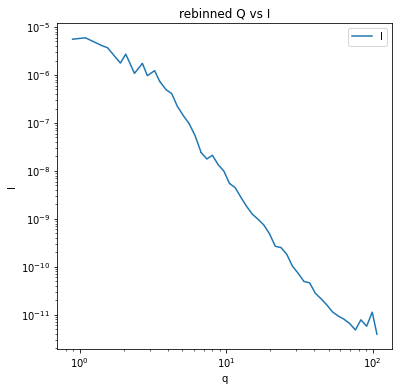

In [56]:

simulation.calculate_custom_FTI_3D_slice(device = 'cpu')
simulation.sinc()
simulation.reBin(200, slice = 'center')
simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

In [57]:
simulation.save_data(directory='dat_files')
print("the cylinder file with radius {r:.3f} and height {h:.3f} is saved".format(r = simulation.rMean, h = simulation.hMean))

the cylinder file with radius 0.360 and height 3.403 is saved


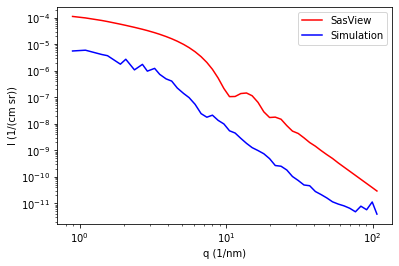

In [58]:
simulation.init_sas_model()
plot_simulation_vs_sas( simulation.binned_slice, simulation.qx_sas, simulation.I_sas)

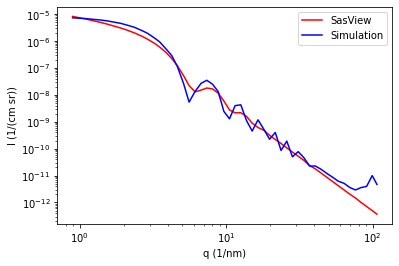

In [8]:

simulation.update_scaling(2.1625e-02)
plot_simulation_vs_sas( simulation.binned_slice, simulation.qx_sas, simulation.I_sas)

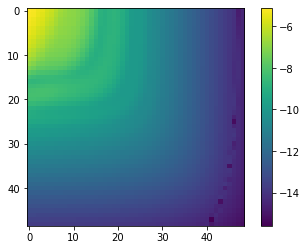

In [9]:
simulation.intensity_2d_sas()
plot_2d_sas(simulation.Intensity_2D_sas)

the maximal difference between the implementation of the FTI is 0.020193370059132576


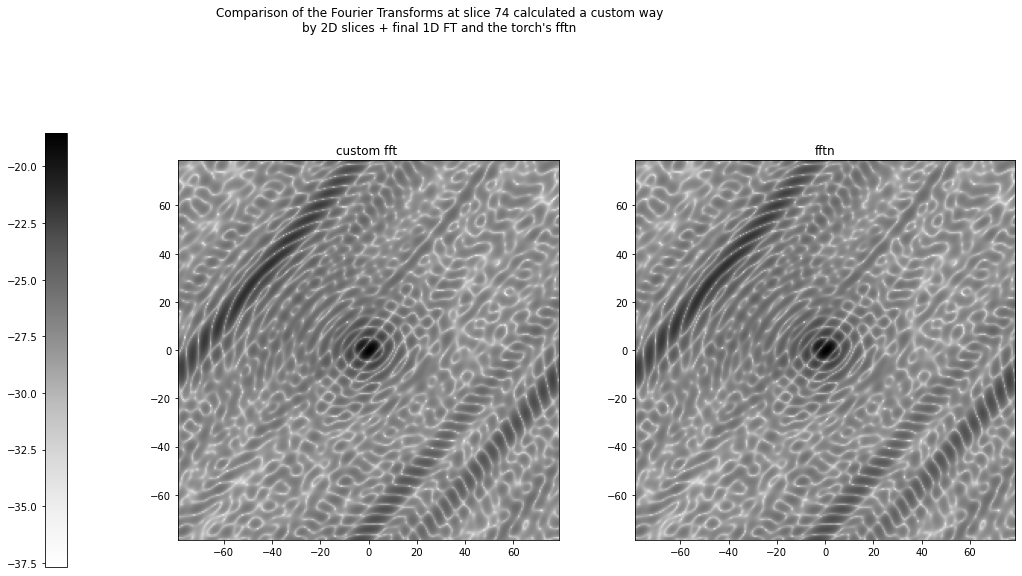

In [10]:

plot_FTI_version(simulation.FTI_custom, simulation.FTI_torch, simulation.qx)

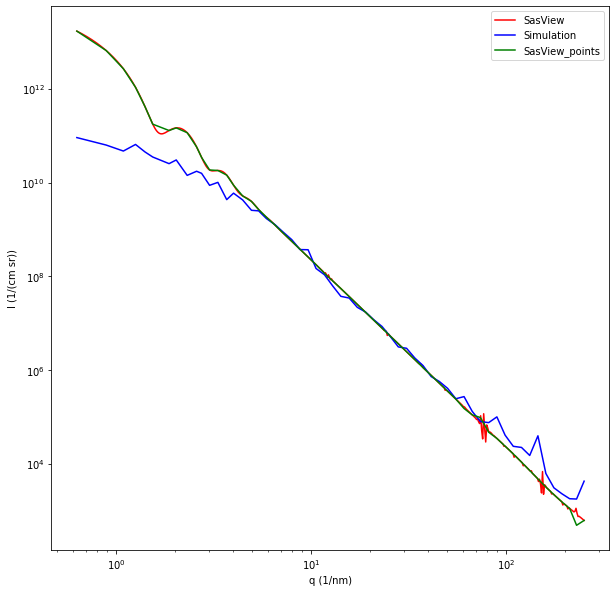

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.plot(q, intensity, '-', color = 'red', label = 'SasView')
plt.plot(simulation.binned_data.Q, simulation.binned_data.I, color = 'blue', label = 'Simulation')
plt.plot(q1, intensity1, '-', color = 'green', label = 'SasView_points')
plt.xlabel("q (1/nm)")
plt.ylabel("I (1/(cm sr))")
plt.xscale('log') 
plt.yscale('log') 
plt.legend()
